<a href="https://colab.research.google.com/github/leonardo3108/robustez-query/blob/main/code/Graphics_Discount_Gain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cálculo do Desconto ou Ganho

In [1]:
! wget -nc https://raw.githubusercontent.com/leonardo3108/robustez-query/main/code/local/util_bd_dataframe.py
! wget -nc https://raw.githubusercontent.com/leonardo3108/robustez-query/main/data/tab_calculated_metric.csv -P data
! wget -nc https://raw.githubusercontent.com/leonardo3108/robustez-query/main/data/tab_noise_kind.csv -P data
! wget -nc https://raw.githubusercontent.com/leonardo3108/robustez-query/main/data/tab_search_context.csv -P data
! wget -nc https://raw.githubusercontent.com/leonardo3108/robustez-query/main/data/tab_original_query.csv -P data

--2021-12-05 13:08:42--  https://raw.githubusercontent.com/leonardo3108/robustez-query/main/code/local/util_bd_dataframe.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14915 (15K) [text/plain]
Saving to: ‘util_bd_dataframe.py’

util_bd_dataframe.p 100%[===================>]  14.57K  --.-KB/s    in 0s      

2021-12-05 13:08:42 (84.8 MB/s) - ‘util_bd_dataframe.py’ saved [14915/14915]

--2021-12-05 13:08:42--  https://raw.githubusercontent.com/leonardo3108/robustez-query/main/data/tab_calculated_metric.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting r

## Obtenção da Base de dados

In [77]:
import util_bd_dataframe  as util_bd_pandas

df_calculated_metric = util_bd_pandas.read_df_calculated_metric_with_label()[['search_context','cod_metric','noise_kind', 'language', 'value','cod_original_query']]
df_calculated_metric

,search_context,cod_metric,noise_kind,language,value,cod_original_query
0,TREC 2020 Judment EN-BM25,DCG@10,No changes in the text,en,1.746141,23849
1,TREC 2020 Judment EN-BM25,DCG@10,No changes in the text,en,7.000000,42255
2,TREC 2020 Judment EN-BM25,DCG@10,No changes in the text,en,24.412392,47210
3,TREC 2020 Judment EN-BM25,DCG@10,No changes in the text,en,7.315465,67316
4,TREC 2020 Judment EN-BM25,DCG@10,No changes in the text,en,3.014736,118440
...,...,...,...,...,...,...
15061,TREC 2020 Judment PT-ReRank@100,DG:nDCG@10,Back translation (with portuguese),pt,11.662980,1132532
15062,TREC 2020 Judment PT-ReRank@100,DG:nDCG@10,Back translation (with portuguese),pt,0.819380,1133579
15063,TREC 2020 Judment PT-ReRank@100,DG:nDCG@10,Back translation (with portuguese),pt,0.000000,1136043
15064,TREC 2020 Judment PT-ReRank@100,DG:nDCG@10,Back translation (with portuguese),pt,0.000000,1136047


In [78]:
df_calculated_metric[['search_context']].value_counts()

search_context                 
TREC 2020 Judment PT-ReRank@100    5184
TREC 2020 Judment EN-DPR           2754
TREC 2020 Judment EN-ReRank@100    1458
TREC 2020 Judment EN-BM25          1458
TREC 2020 Full-ReRank@1000         1458
TREC 2020 Full-BM25                1458
TREC 2020 Judment PT-BM25          1296
dtype: int64

In [80]:
df_dg_nDCG10 = df_calculated_metric.query('cod_metric == "DG:nDCG@10" and language == "en" and search_context in ["TREC 2020 Full-BM25", "TREC 2020 Full-ReRank@1000", "TREC 2020 Judment EN-DPR"] and value <= 5')[['search_context', 'noise_kind', 'cod_original_query', 'value']]
df_dg_nDCG10

,search_context,noise_kind,cod_original_query,value
1566,TREC 2020 Judment EN-DPR,No changes in the text,23849,0.000000
1567,TREC 2020 Judment EN-DPR,No changes in the text,42255,0.000000
1568,TREC 2020 Judment EN-DPR,No changes in the text,47210,0.000000
1569,TREC 2020 Judment EN-DPR,No changes in the text,67316,0.000000
1570,TREC 2020 Judment EN-DPR,No changes in the text,118440,0.000000
...,...,...,...,...
5827,TREC 2020 Full-ReRank@1000,With one typographical error,1030303,-0.045667
5828,TREC 2020 Full-ReRank@1000,With one typographical error,1037496,-0.999990
5829,TREC 2020 Full-ReRank@1000,With one typographical error,1043135,-0.036319
5830,TREC 2020 Full-ReRank@1000,With one typographical error,1051399,-0.999988


# Mudando estrutura para query x ruido

In [81]:
import pandas as pd

desconto_ganho = {}
for row in df_dg_nDCG10.itertuples():
    if row.cod_original_query not in desconto_ganho:
        desconto_ganho[row.cod_original_query] = {}
    desconto_ganho[row.cod_original_query][(row.search_context, row.noise_kind)] = row.value
df_desconto_ganho = pd.DataFrame.from_dict(desconto_ganho, orient='index')
df_desconto_ganho.index.name = 'cod_original_query'
df_desconto_ganho.head()

TREC 2020 Judment EN-DPR  ...          TREC 2020 Full-BM25
                     No changes in the text  ... With one typographical error
cod_original_query                           ...                             
23849                                   0.0  ...                          NaN
42255                                   0.0  ...                    -0.241234
47210                                   0.0  ...                     0.048791
67316                                   0.0  ...                     0.161555
118440                                  0.0  ...                     0.000000

[5 rows x 27 columns]

# Tirando a média entre as queries

In [82]:
df_desconto_ganho_medio = df_desconto_ganho.mean().unstack().T
df_desconto_ganho_medio = df_desconto_ganho_medio.reindex(['TREC 2020 Full-BM25', 'TREC 2020 Full-ReRank@1000', 'TREC 2020 Judment EN-DPR'], axis=1)
df_desconto_ganho_medio = df_desconto_ganho_medio.reindex(['No changes in the text', 'Permutation of words: first and last', 'Permutation of words: first and second', 'Permutation of words: last and penultimate', 'Deletion of words by probability: 20% (at least the central word)', 'Deletion of words in positions: [2]', 'Deletion of words in positions: [penultimate]', 'With one typographical error', 'Back translation (with portuguese)'], axis=0)
df_desconto_ganho_medio

,TREC 2020 Full-BM25,TREC 2020 Full-ReRank@1000,TREC 2020 Judment EN-DPR
No changes in the text,0.000000,0.000000,0.000000
Permutation of words: first and last,0.000000,0.032533,0.049826
Permutation of words: first and second,0.000000,-0.033821,0.130844
Permutation of words: last and penultimate,0.000000,-0.028313,-0.032515
Deletion of words by probability: 20% (at least the central word),-0.301007,-0.240406,-0.155110
Deletion of words in positions: [2],-0.128180,-0.225937,-0.124163
Deletion of words in positions: [penultimate],-0.308150,-0.118572,-0.162071
With one typographical error,-0.030610,0.040234,-0.033583
Back translation (with portuguese),-0.152210,-0.143807,-0.091720


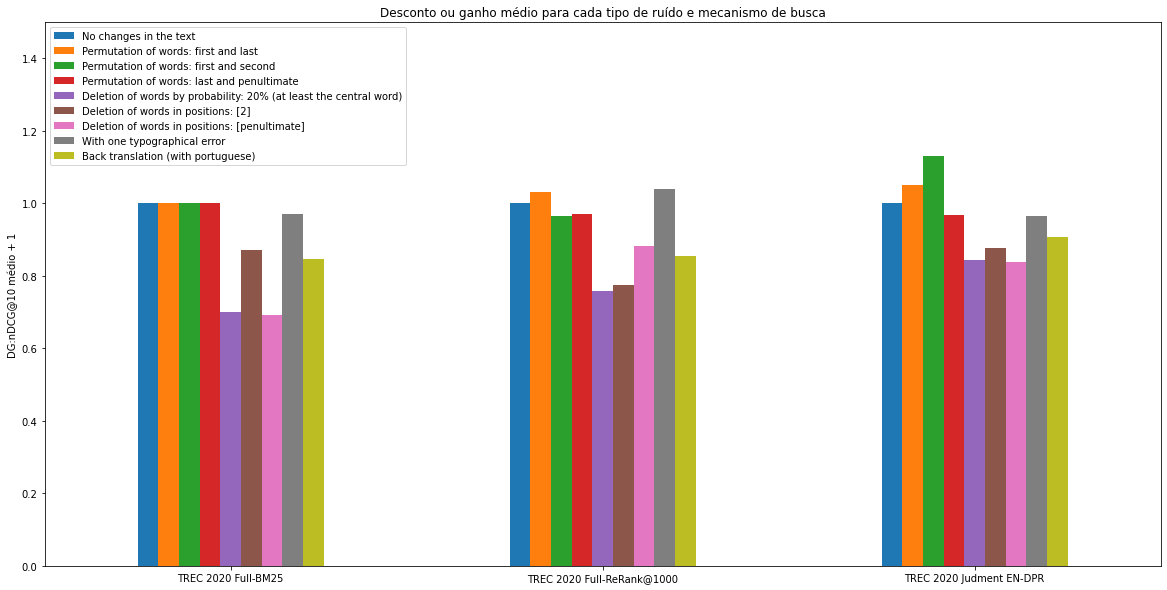

In [83]:
import matplotlib.pyplot as plt

(df_desconto_ganho_medio+1).T.plot.bar(rot=0, figsize=(20,10), title='Desconto ou ganho médio para cada tipo de ruído e mecanismo de busca', ylabel='DG:nDCG@10 médio + 1', ylim=(0,+1.5))
plt.show()

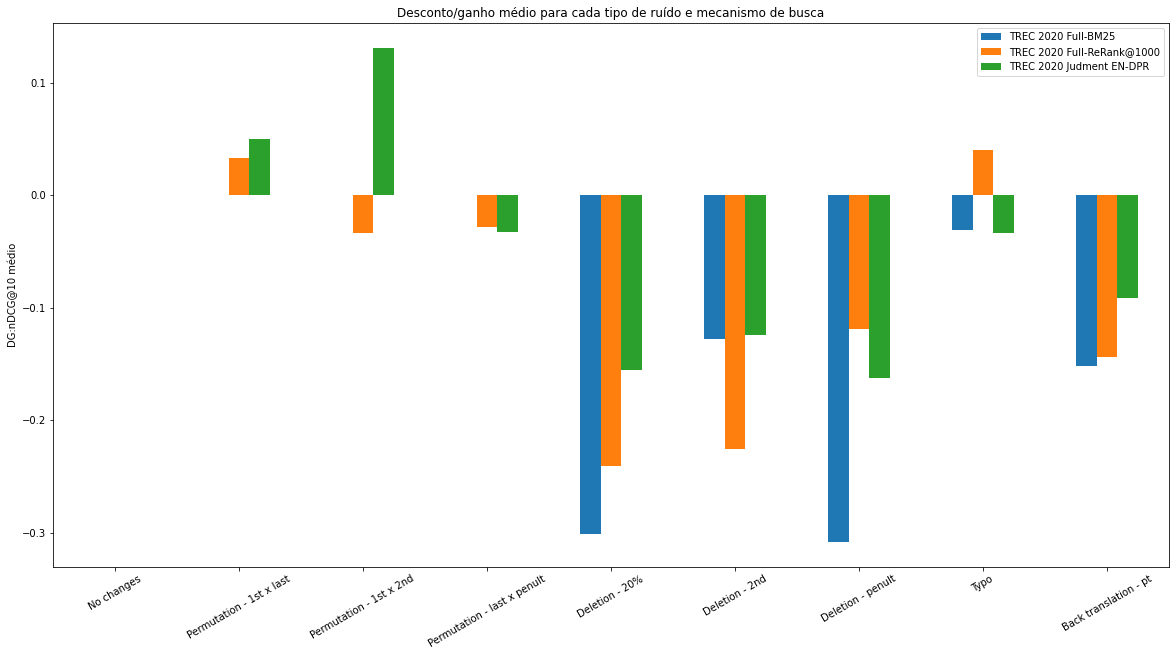

In [84]:
df_desconto_ganho_medio.rename(index={'No changes in the text': 'No changes', 
                                      'Permutation of words: first and last': 'Permutation - 1st x last', 
                                      'Permutation of words: first and second': 'Permutation - 1st x 2nd',
                                      'Permutation of words: last and penultimate': 'Permutation - last x penult',
                                      'Deletion of words by probability: 20% (at least the central word)': 'Deletion - 20%', 
                                      'Deletion of words in positions: [2]': 'Deletion - 2nd',
                                      'Deletion of words in positions: [penultimate]': 'Deletion - penult',
                                      'With one typographical error': 'Typo',
                                      'Back translation (with portuguese)': 'Back translation - pt'}).plot.bar(rot=30, figsize=(20,10), title='Desconto/ganho médio para cada tipo de ruído e mecanismo de busca', ylabel='DG:nDCG@10 médio')
plt.show()

# Distribuições

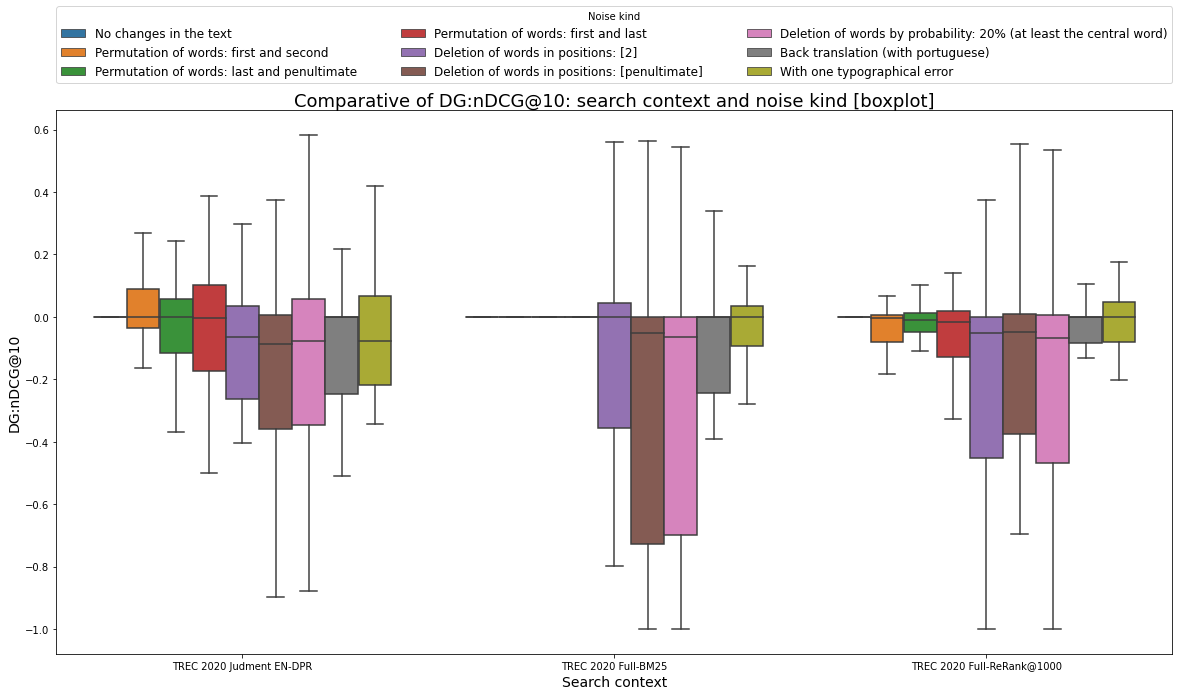

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.boxplot(x="search_context", hue="noise_kind", y="value", ax=ax, data=df_dg_nDCG10, showfliers = False)
plt.xlabel('Search context', fontsize=14)
plt.ylabel('DG:nDCG@10', fontsize=14)
ax.set_title('Comparative of DG:nDCG@10: search context and noise kind [boxplot]', y=1.0, pad=-14, fontsize=18)
plt.legend(bbox_to_anchor=(0., 1.05, 1., 1.02), loc=3, ncol=3,  borderaxespad=0., mode="expand", fontsize=12, title = 'Noise kind') 
plt.show()

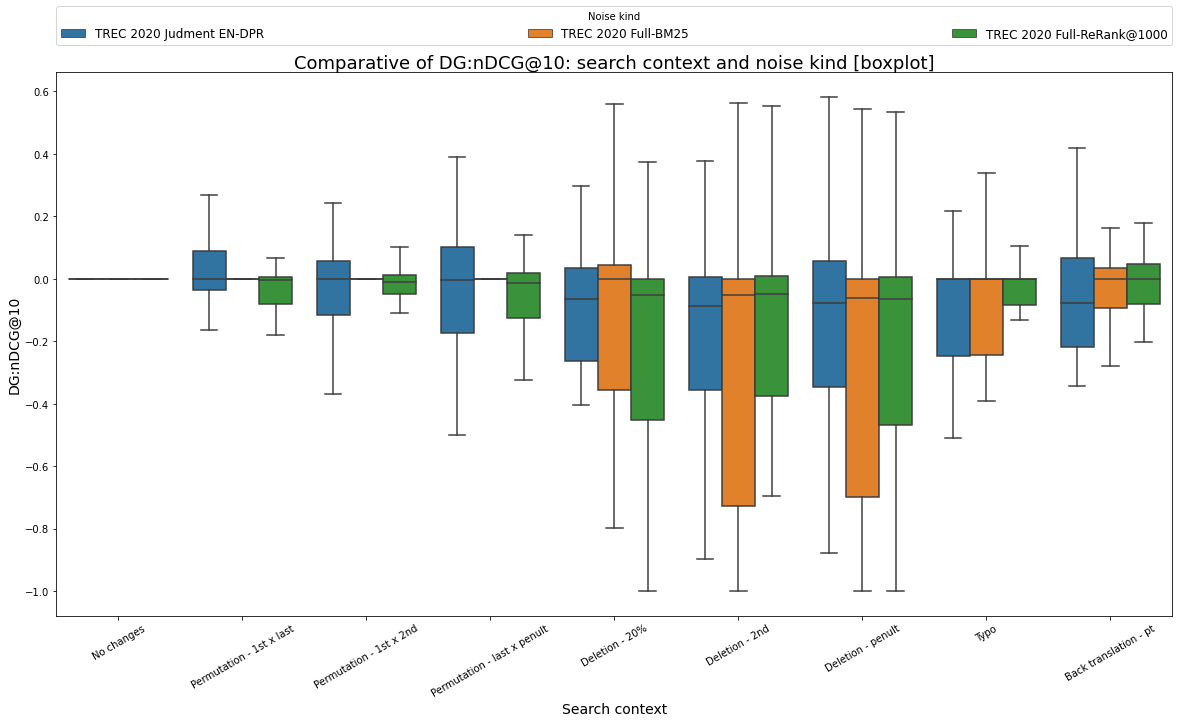

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.boxplot(x="noise_kind", hue="search_context", y="value", ax=ax, data=df_dg_nDCG10, showfliers = False)
ax.set_xticklabels(['No changes', 'Permutation - 1st x last', 'Permutation - 1st x 2nd', 'Permutation - last x penult', 'Deletion - 20%', 'Deletion - 2nd', 'Deletion - penult', 'Typo', 'Back translation - pt'],rotation=30)
plt.xlabel('Search context', fontsize=14)
plt.ylabel('DG:nDCG@10', fontsize=14)
ax.set_title('Comparative of DG:nDCG@10: search context and noise kind [boxplot]', y=1.0, pad=-14, fontsize=18)
plt.legend(bbox_to_anchor=(0., 1.05, 1., 1.02), loc=3, ncol=4,  borderaxespad=0., mode="expand", fontsize=12, title = 'Noise kind') 
plt.show()

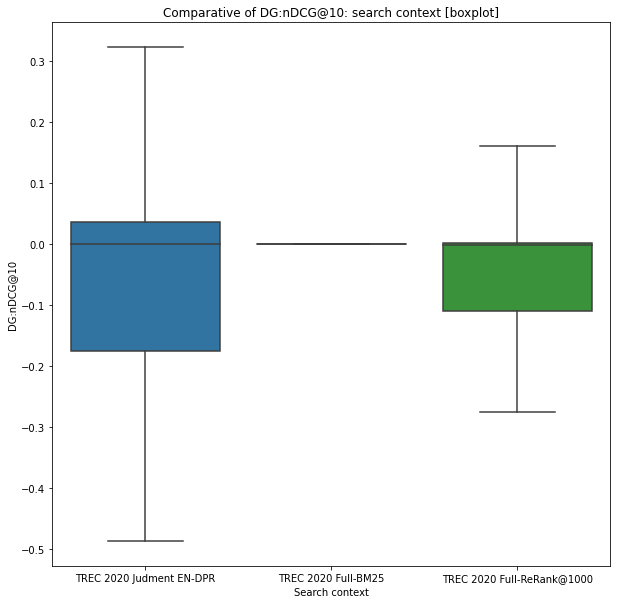

In [87]:
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.boxplot(x="search_context", y="value", ax=ax, data=df_dg_nDCG10, showfliers = False)
ax.set(ylabel = 'DG:nDCG@10', xlabel = 'Search context')
ax.set_title('Comparative of DG:nDCG@10: search context [boxplot]')
fig.savefig('graphics\comparative_search_context_boxplot', transparent=False, dpi=80, bbox_inches='tight')
plt.show()

# Análise de queries

In [88]:
df_original_query = util_bd_pandas.read_df_original_query()[0].query('language == "en"')[['cod', 'text']].set_index('cod')
df_original_query

,text
cod,
23849,are naturalization records public information
42255,average salary for dental hygienist in nebraska
47210,average wedding dress alteration cost
67316,can fever cause miscarriage early pregnancy
118440,define bmt medical
121171,define etruscans
135802,definition of laudable
141630,describe how muscles and bones work together t...
156498,do google docs auto save


In [137]:
def build_graph(noise, short):
    df1 = df_dg_nDCG10.query('noise_kind == "' + noise + '"')[['cod_original_query', 'search_context', 'value']].set_index('cod_original_query')
    df2 = pd.DataFrame(index=df_original_query.index)
    for search_context in search_contexts:
        df2[search_context] = df1.query('search_context == "' + search_context + '"')['value']
    df2['Text'] = df_original_query['text']
    df2['sort'] = abs(df2['TREC 2020 Full-ReRank@1000']) + abs(df2['TREC 2020 Judment EN-DPR']) + abs(df2['TREC 2020 Full-BM25'])
    df2 = df2.dropna()
    df2 = df2.sort_values('sort', ascending=False)
    df2

    import numpy as np
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(10, 20))
    ax = fig.subplots()
    data = df2.to_dict(orient='index')

    Y = np.zeros(10)
    yticklabels = []

    def plot_query(x, y, linestyle, dotstyle, color, label):
        if y:
            label = None
        if x > 1: x = 1
        ax.plot(np.linspace(0, x, 10), Y+i, linestyle=linestyle, linewidth=1.5, color=color)
        ax.plot(x, y, dotstyle, label=label)

    formato = ['solid', 'dashed', 'dotted']
    cores =   ['blue', 'green', 'red']
    marcas =  ['bo', 'gs', 'rd']

    for i, query in enumerate(data.keys()):
      valores = np.array([data[query]['TREC 2020 Full-BM25']
                          ,data[query]['TREC 2020 Full-ReRank@1000']
                          ,data[query]['TREC 2020 Judment EN-DPR']
                          ])

      #print(valores)
      ordem = (-valores).argsort()

      for pos in range(len(ordem)):
        prox_pos = ordem[pos]
        plot_query(data[query][search_contexts[prox_pos]], i, formato[prox_pos], marcas[prox_pos], cores[prox_pos], search_contexts[prox_pos].split('_')[0])

      yticklabels.append(data[query]['Text'])

    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    ax.set_title(noise)
    ax.set(ylim=(-1, len(data)+4.5),
            yticks=np.arange(len(data)), 
            xticks=np.arange(-1.0, 1.10, .20),
            yticklabels=yticklabels)
    ax.set_xlabel('DG:nDCG@10')
    ax.tick_params(left=False, bottom=True, labelbottom=True)
    fig.savefig('dg_ndcg10_' + short + '.png', transparent=False, dpi=80, bbox_inches='tight')

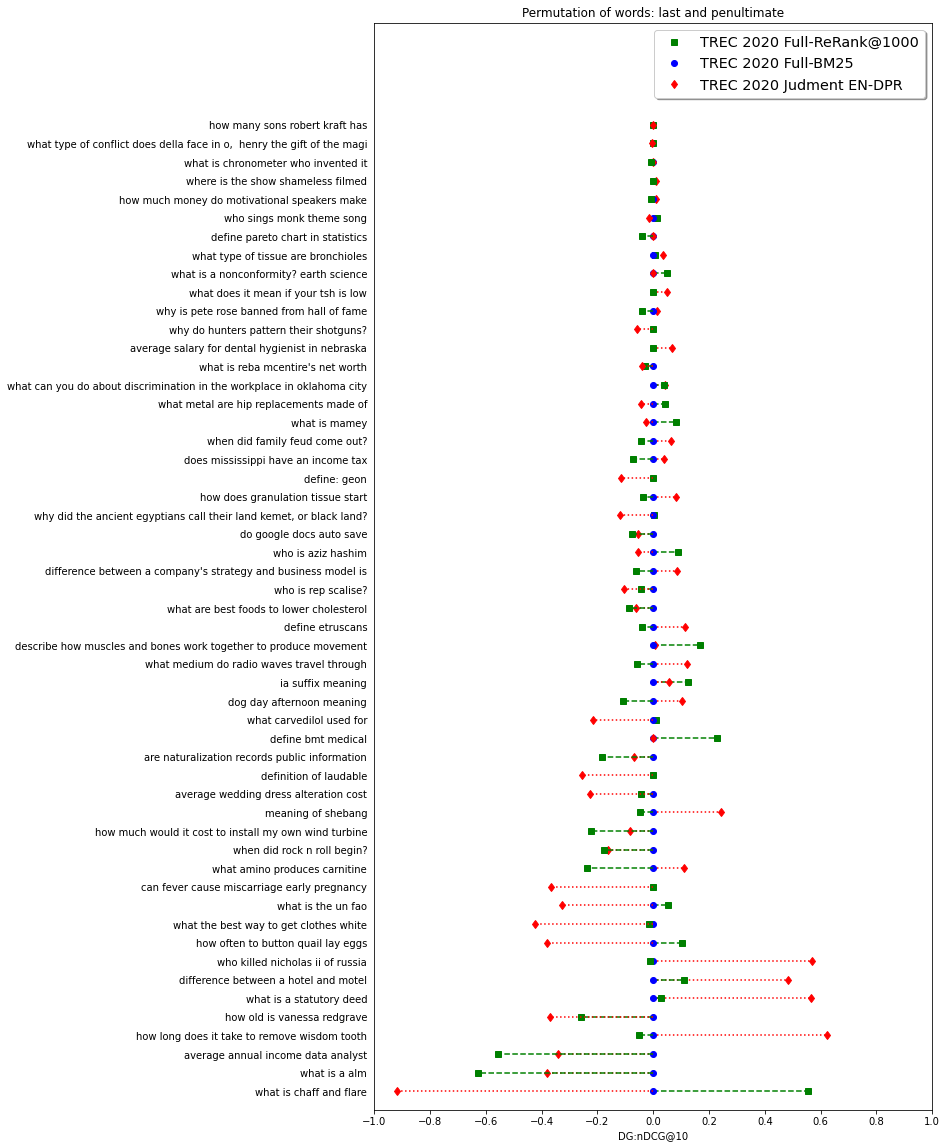

In [138]:
noise = 'Permutation of words: last and penultimate'
short = 'permutation_first_second'
build_graph(noise, short)

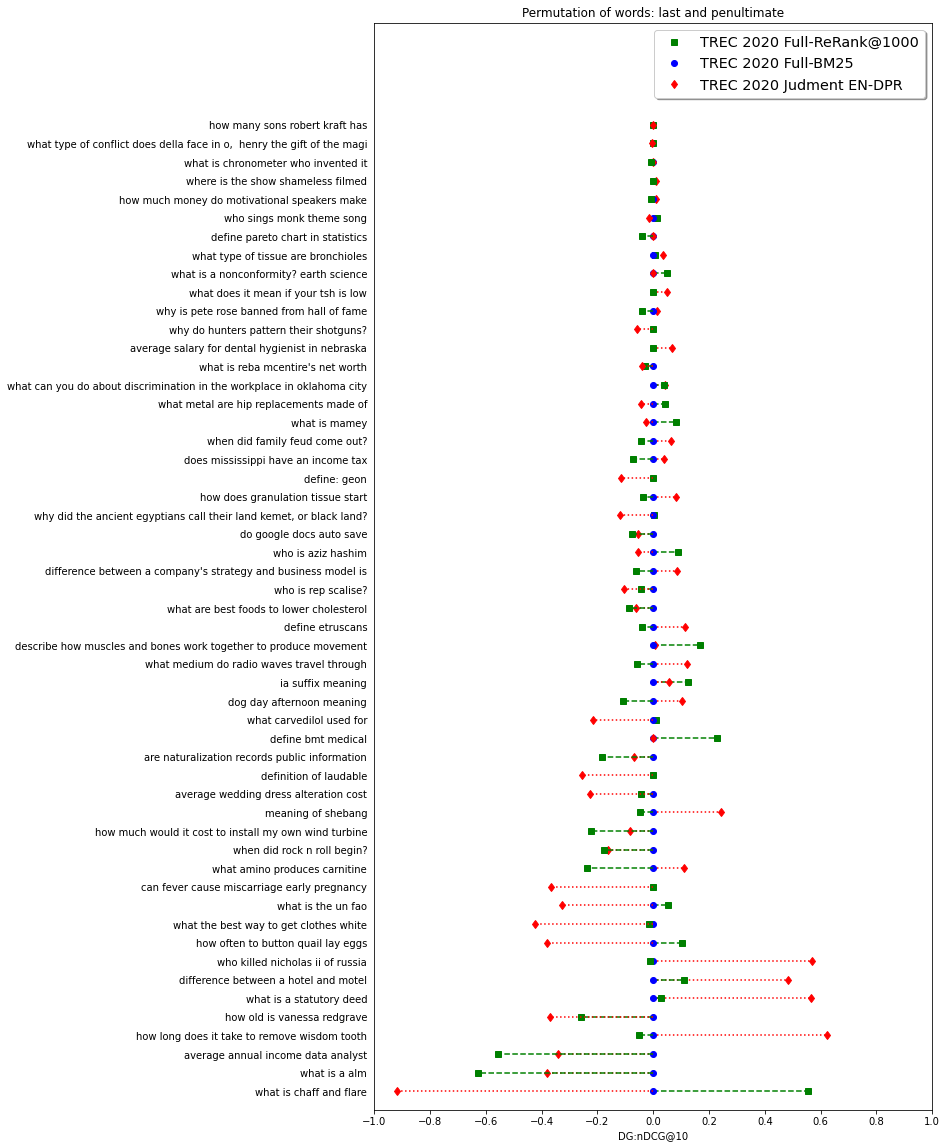

In [142]:
noise = 'Permutation of words: last and penultimate'
short = 'permutation_last_penultimate'
build_graph(noise, short)

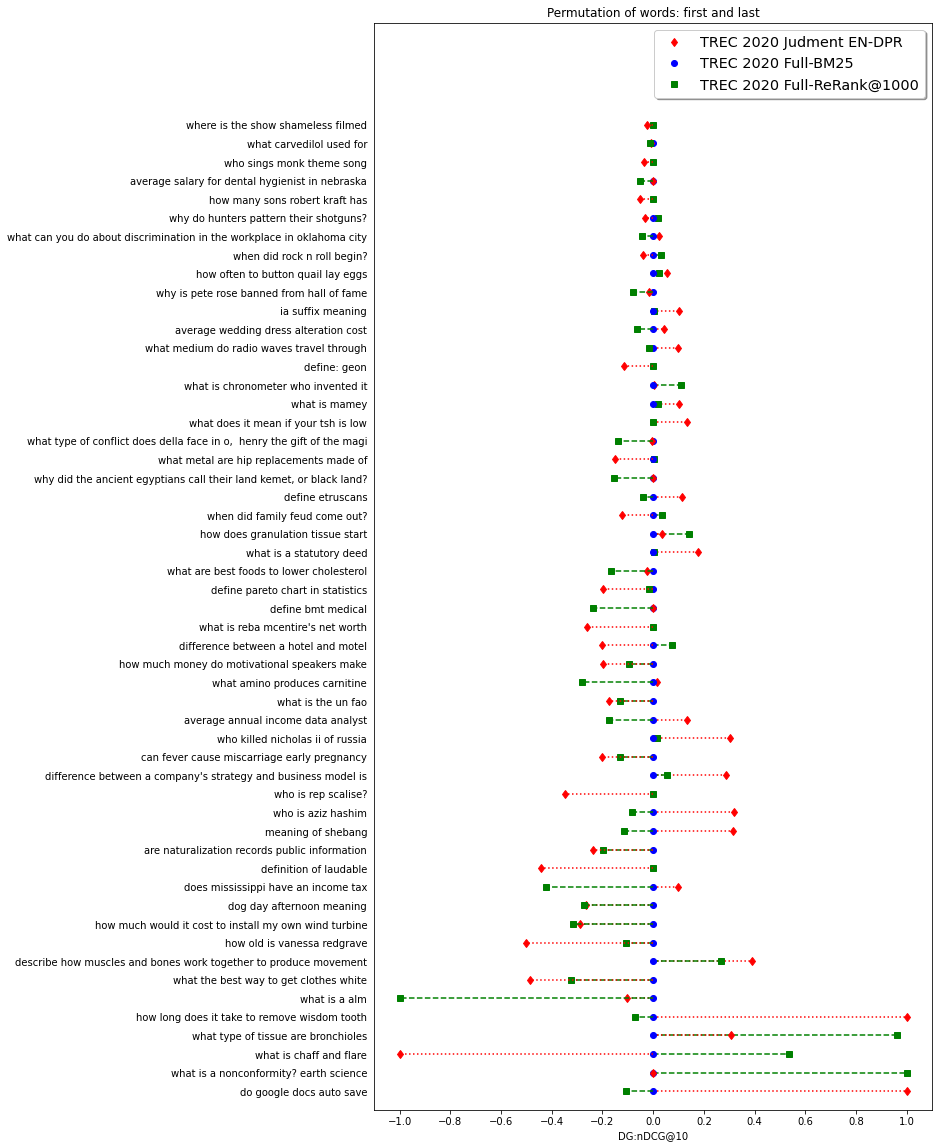

In [143]:
noise = 'Permutation of words: first and last'
short = 'permutation_first_last'
build_graph(noise, short)

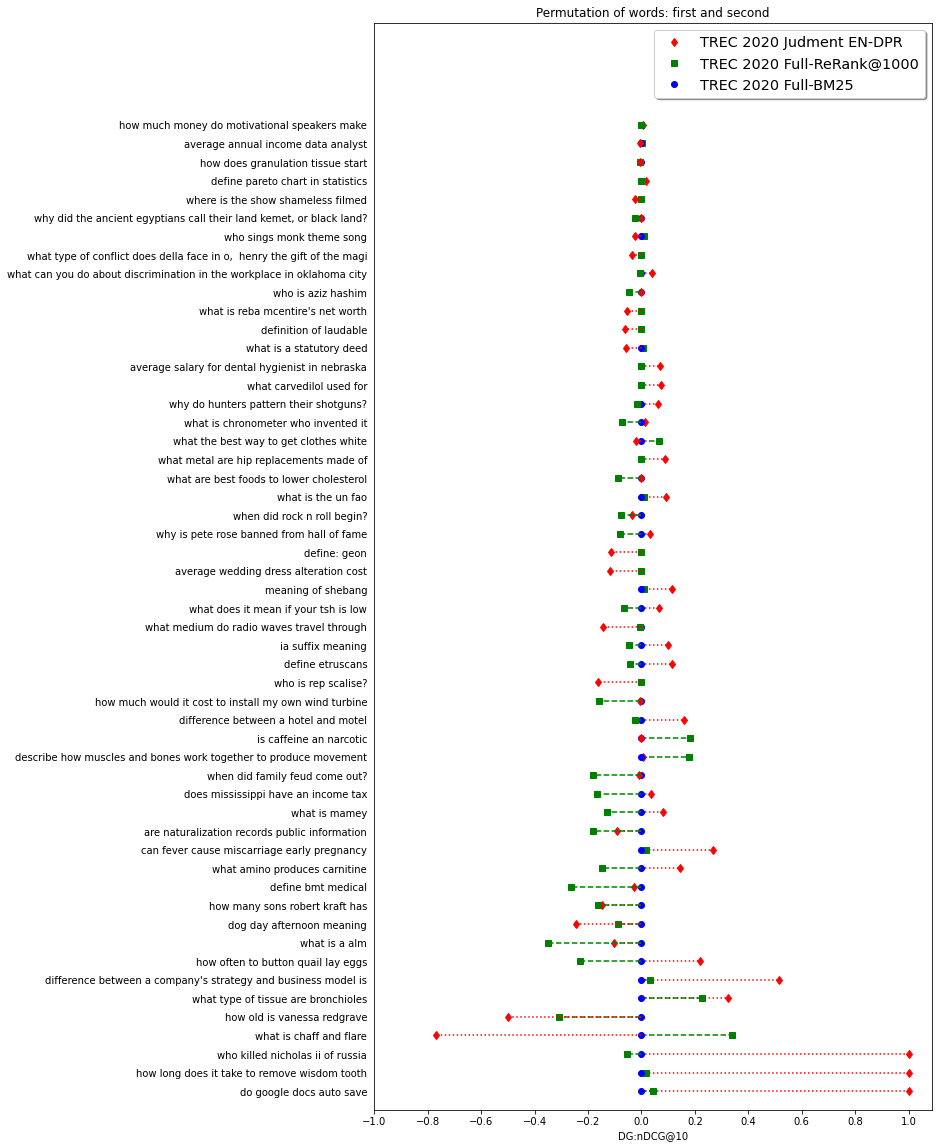

In [144]:
noise = 'Permutation of words: first and second'
short = 'permutation_first_second'
build_graph(noise, short)

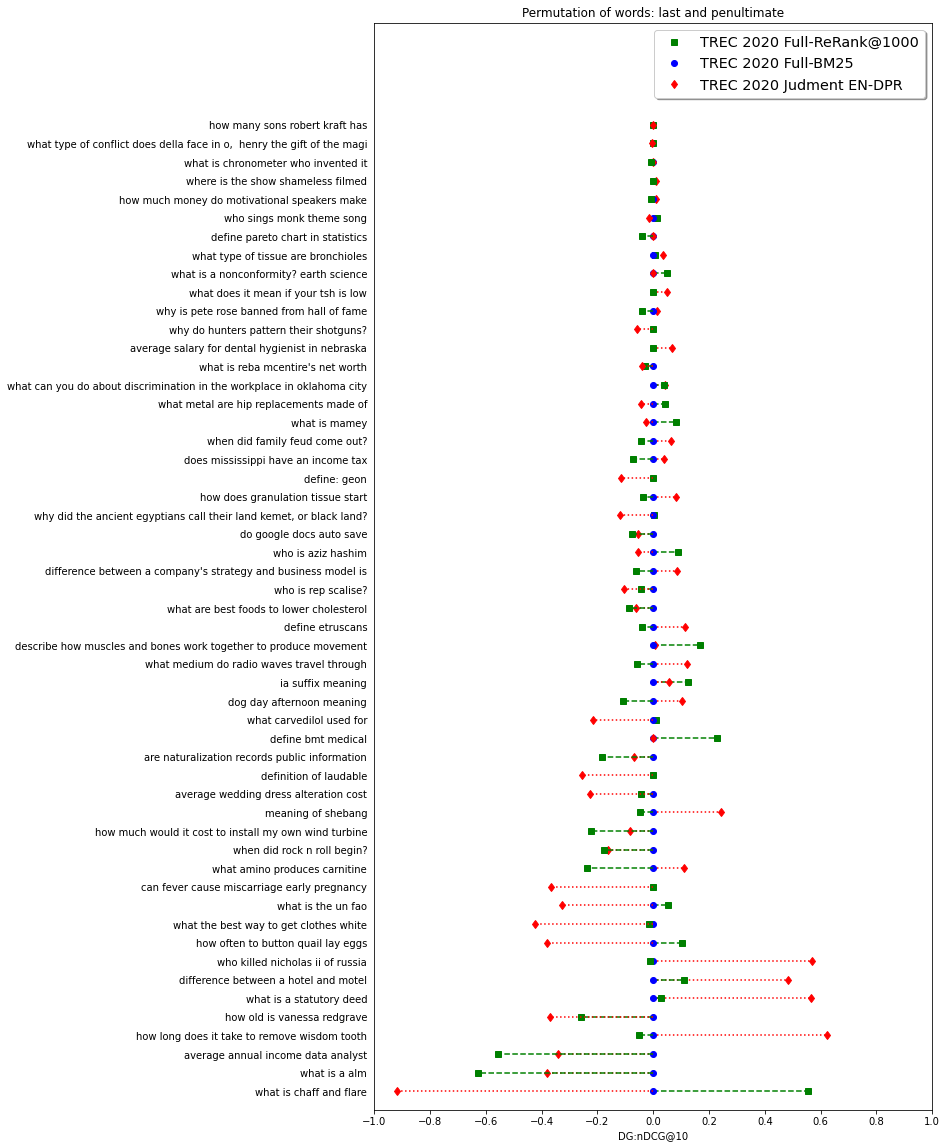

In [145]:
noise = 'Permutation of words: last and penultimate'
short = 'permutation_last_penultimate'
build_graph(noise, short)

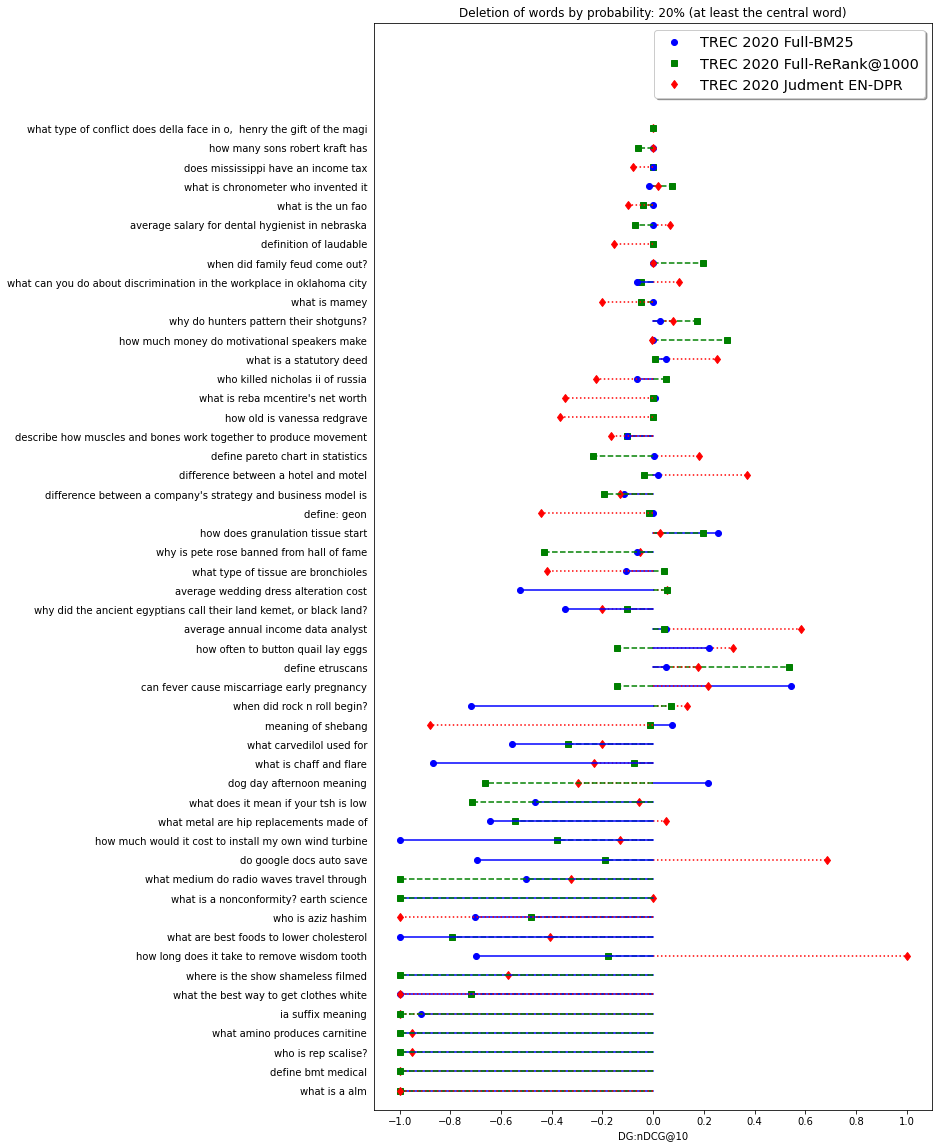

In [146]:
noise = 'Deletion of words by probability: 20% (at least the central word)'
short = 'deletion_probability20'
build_graph(noise, short)

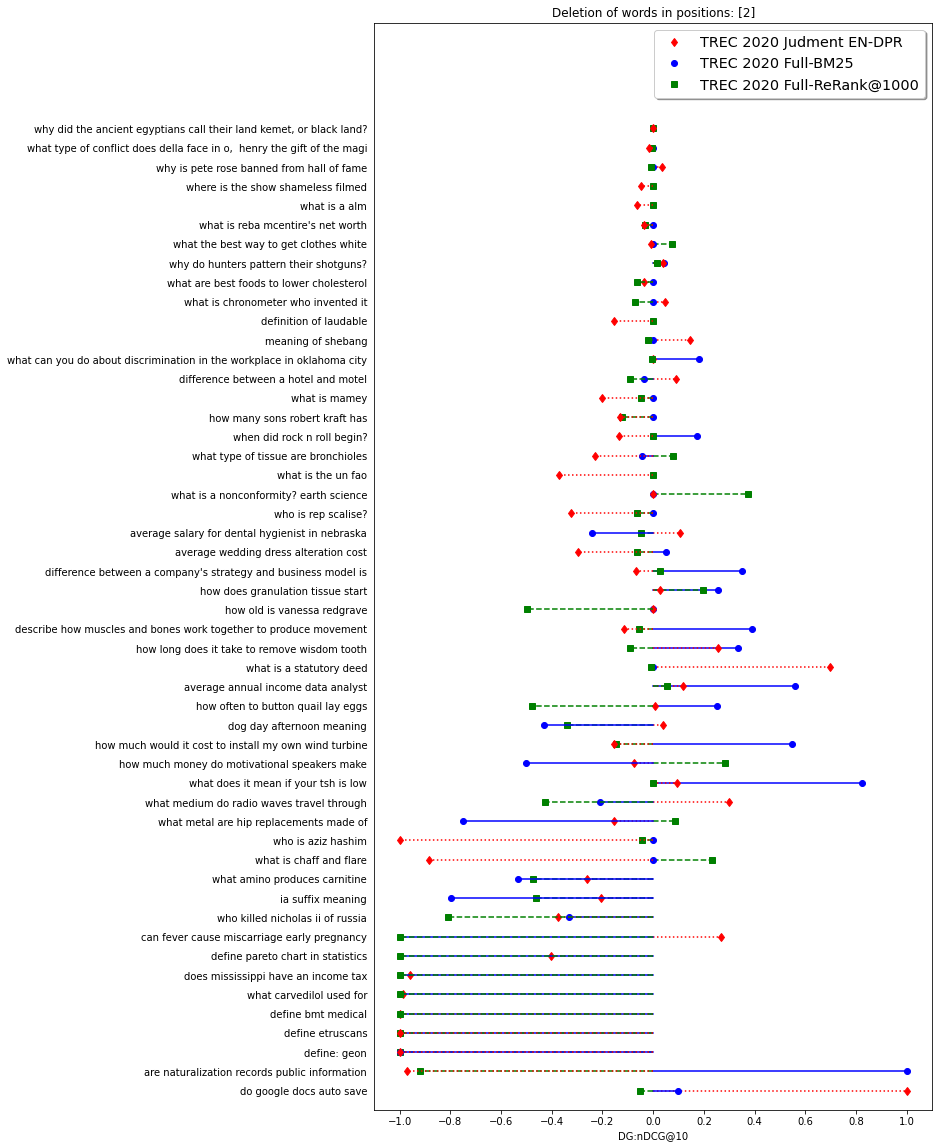

In [147]:
noise = 'Deletion of words in positions: [2]'
short = 'deletion_position2'
build_graph(noise, short)

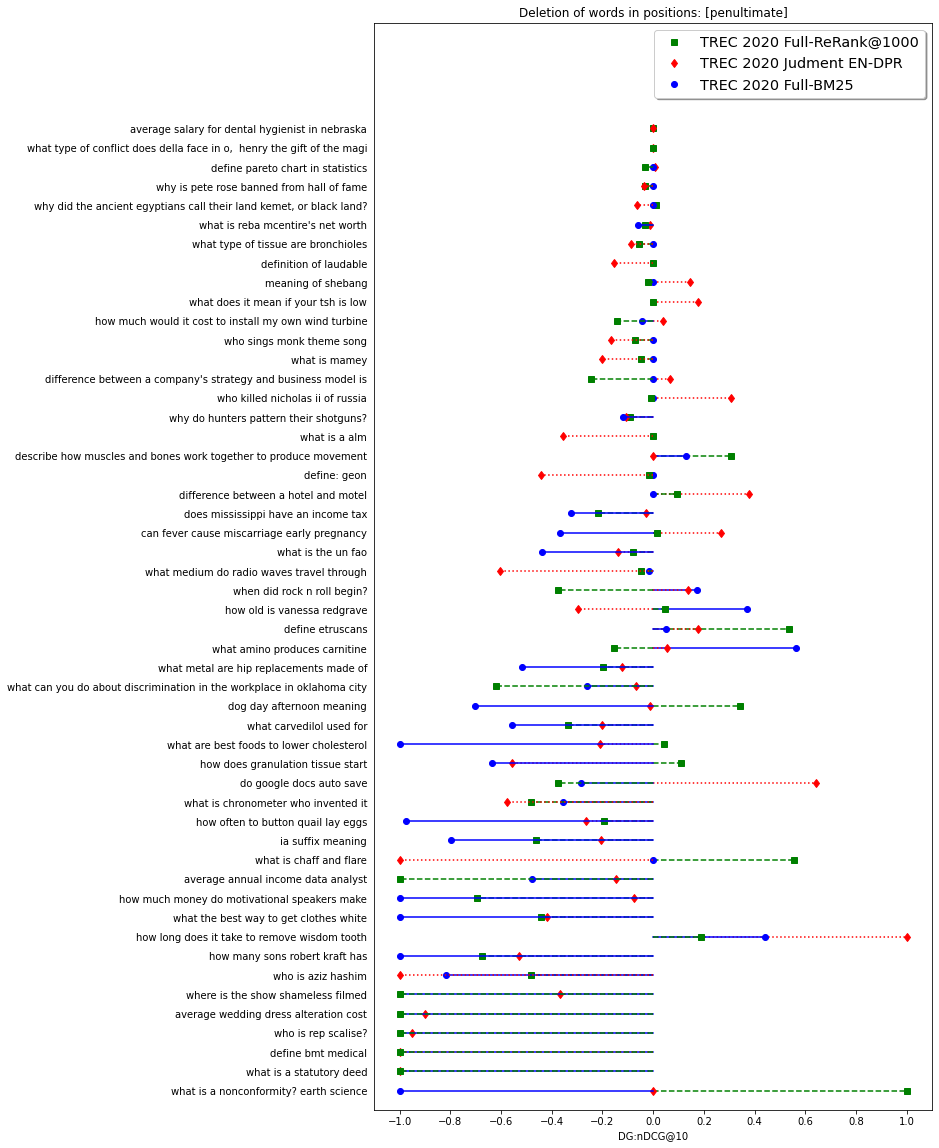

In [148]:
noise = 'Deletion of words in positions: [penultimate]'
short = 'deletion_position_penultimate'
build_graph(noise, short)

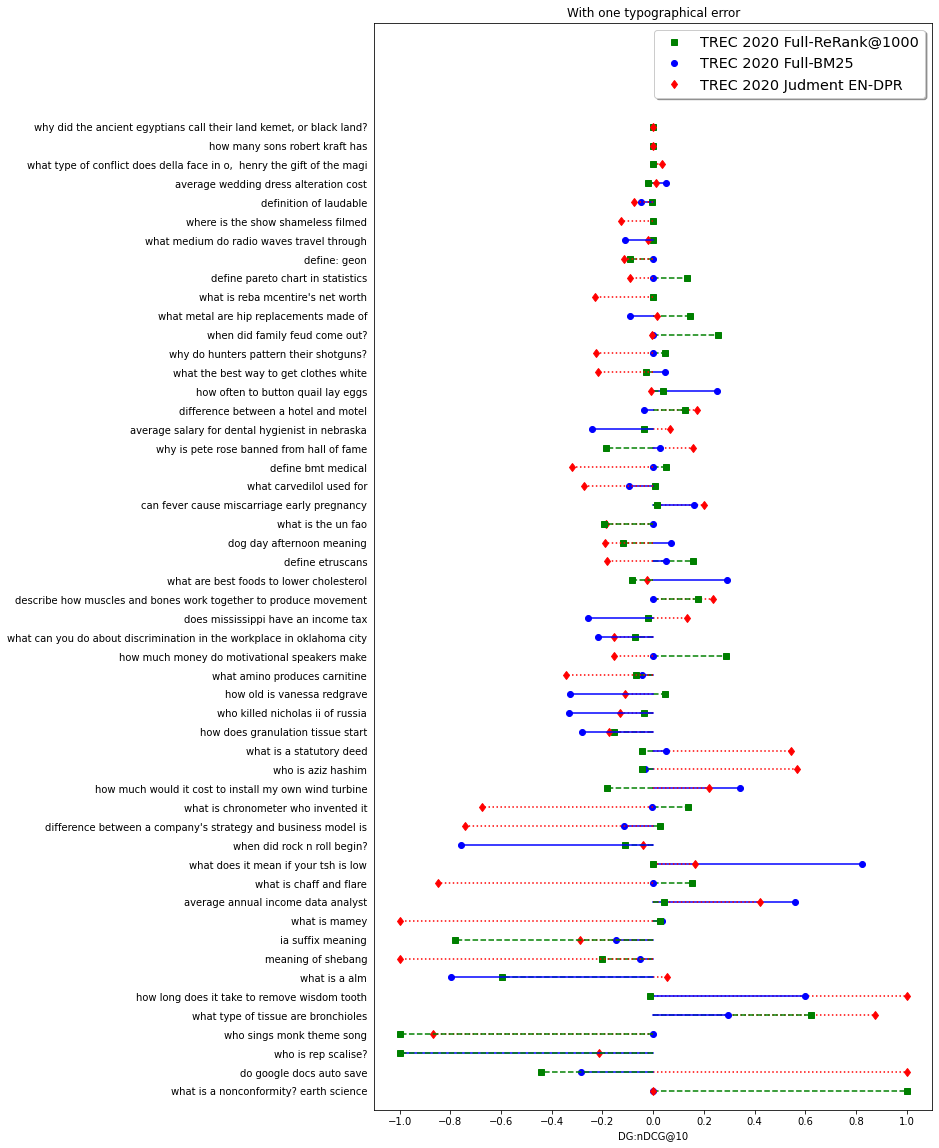

In [149]:
noise = 'With one typographical error'
short = 'typo'
build_graph(noise, short)

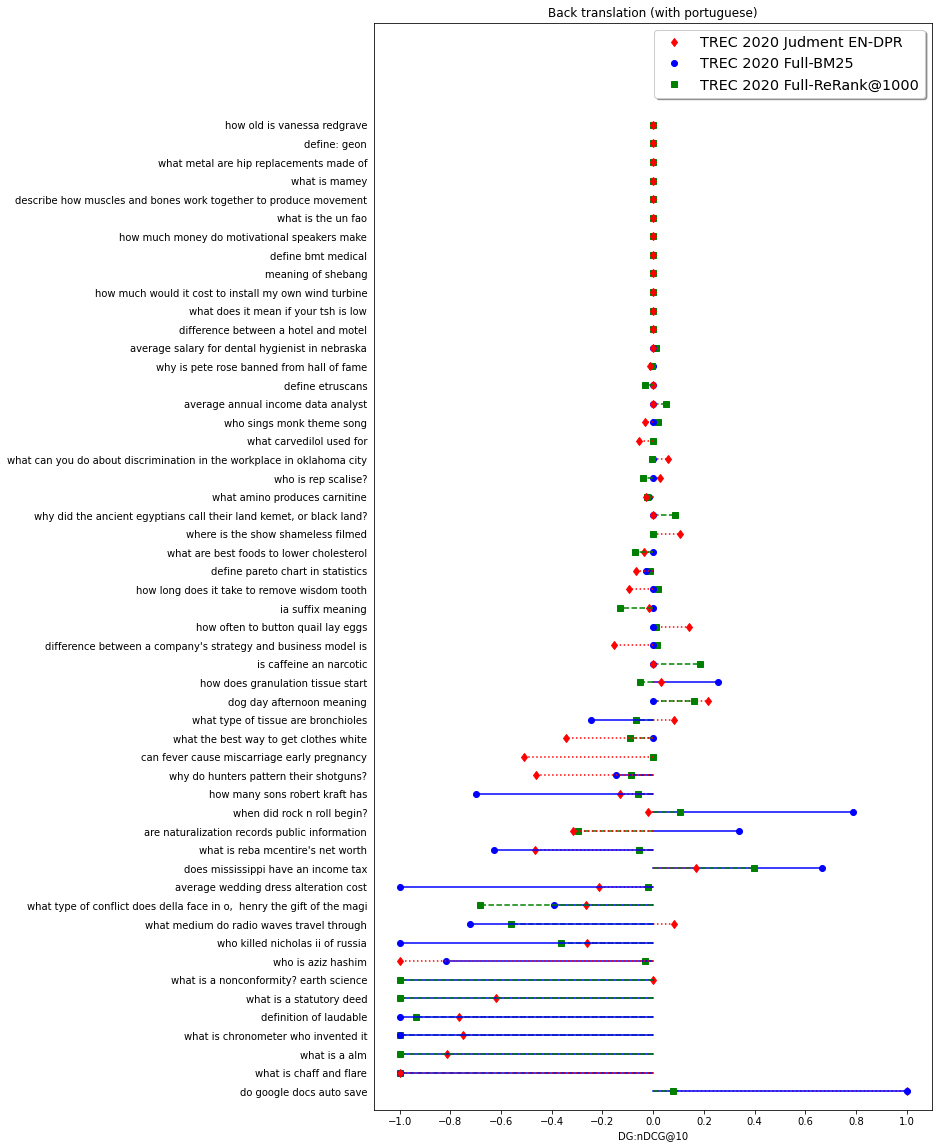

In [150]:
noise = 'Back translation (with portuguese)'
short = 'back-translation-pt'
build_graph(noise, short)